# Lab 5 Scalable Shor’s Algorithm

Prerequisites:
- [Ch.3.7 Shor's Algorithm](https://qiskit.org/textbook/ch-algorithms/shor.html)

Other relevant materials:
- [Experimental demonstration of Shor’s algorithm with quantum entanglement](https://arxiv.org/pdf/0705.1398.pdf)
- [Realization of a scalable Shor algorithm](https://arxiv.org/pdf/1507.08852.pdf)

In [1]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
import matplotlib.pyplot as plt

In [2]:
sim = Aer.get_backend('aer_simulator')
shots = 20000

## Part 1: Quantum circuit for Shor's algorithm

<!-- ::: q-block.exercise -->

### Goal

Construct a compiled version of quantum circuit for Shor's algorithm.

<!-- ::: -->
 
Shor's algorithm consists of the following steps; choose a co-prime $a$, where $a \in [2, N-1]$ and the greatest common divisor of $a$ and $N$ is 1, find the order of $a$ modulo $N$, the smallest integer $r$ such that $a^{r}modN = 1$, and then obtain the factor of $N$ by computing the greatest common divisor of $a^{r/2} \pm 1$ and $N$. In this procedure, the second step, finding the order of $a$ modulo $N$, is the only quantum part, *quantum order-finding*.  

In [Ch.3.9 Shor's Algorithm](https://qiskit.org/textbook/ch-algorithms/shor.html), we built a quantum circuit to find the order for $a=7$ and $N=15$. However, as we are very well aware by now, such a large depth circuit is not practical to run on near-term quantum systems due to the presence of noise. Here in part 1 of this lab, we construct a practical quantum circuit for the same example, which could generate a meaningful solution when executed on today's quantum computers. 

In general, the quantum order-finding circuit to factorize the number $N$ requires $m = [log_{2}(N)]$ qubits in the computational (auxiliary) register and $2m (=t)$qubit in the period ( counting ) registers .i.e. total $3m$ qubits, at minimum.  Therefore, 12 qubits were used in the quantum circuit to factorize the number 15 in [Ch.3.9 Shor's Algorithm](https://qiskit.org/textbook/ch-algorithms/shor.html). In addition, the controlled unitary operator for the modular function, $f(x) = a^xmodN$ was applied in a cascading manner as shown in the figure below to produce the highly entangled state $\Sigma^{2^m-1}_{x=0}|x\rangle|a^xmodN>$, which increases the circuit depth substantially.  However the size of the circuit can be reduced based on several observations.

![](image/L5_Circ_gen.svg)

### 1. Remove redundancy.

#### Step A. Run the following cell to create the gate `U` for the function `7mod15`.

The unitary operator $U$ is defined as $U|x\rangle \equiv |7x(mod15)\rangle$.

In [6]:
## Create 7mod15 gate
N = 15
m = int(np.ceil(np.log2(N)))

U_qc = QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)

U = U_qc.to_gate()
U.name ='{}Mod{}'.format(7, N)

&#128211; Confirm if the unitary operator $U$ works properly by creating a quantum circuit with $m$ qubits.  Prepare the input state representing any integer between 0 and 15 (exclusive) such as $|1\rangle (=|0001\rangle), |5\rangle (=|0101\rangle), |13\rangle (=|1101\rangle)$ etc., and apply $U$ gate on it. Check if the circuit produces the expected outcomes for several inputs.  The outcome state for the input $|1\rangle$ should be $|7\rangle (=|0111>$) and $|1\rangle$ for the input $|13\rangle$, for example. 

In [136]:
### your code goes here


















#### &#128211;Step B. Create a quantum circuit with $m$ qubits implementing $U$ gate $4(=2^{2})$ times and run it on the `aer_simulator` to obtain the matrix resprentation of the gates in the circuit.  Verify $U^{2^{2}} = I $  

As shown in the above figure, modular exponentiation is realized by implementing the controlled unitary operator $U$ on each qubit $2^{n}$ times in series when $n$ goes from 0 to 7 for our example.  However, we will find out that whole sets of operations are redundant when $n > 1$ for `7mod15` case, hence the redundant operation can be removed from the circuit.   

In [1]:
### your code goes here
















#### Step C. Run the cells below to see the reduced circuit, `shor_QPE`, and execute it on the `aer_simulator` to check if it reproduce the estimated phases in the Qiskit textbook Ch.3.9. 

In [3]:
def cU_multi(k):
    circ = QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)
    
    cU_multi = U_multi.control()
    return cU_multi

In [4]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

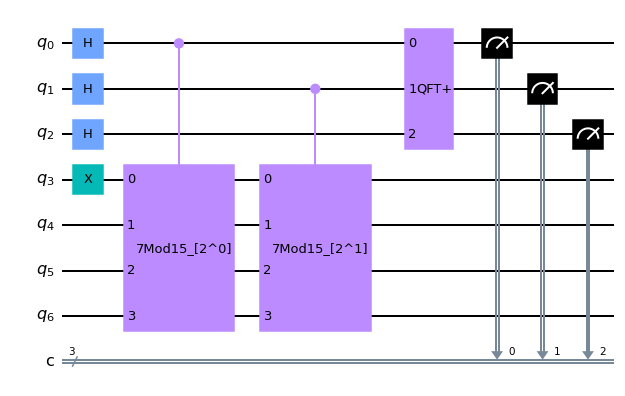

In [9]:
# QPE circuit for Shor
t = 3 
shor_QPE = QuantumCircuit(t+m, t)
shor_QPE.h(range(t))

shor_QPE.x(t)
for idx in range(t-1):
    shor_QPE.append(cU_multi(idx), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'

shor_QPE.append(qft_dag, range(t))
shor_QPE.measure(range(t), range(t))

shor_QPE.draw()

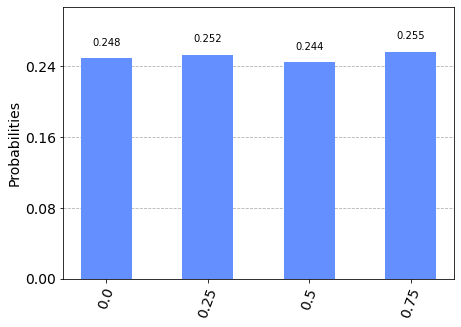

In [10]:
shor_QPE_trans = transpile(shor_QPE, sim)
count_QPE = sim.run(shor_QPE_trans, shots=shots).result().get_counts()
key_new = [str(int(key,2)/2**3) for key in count_QPE.keys()]
count_new_QPE = dict(zip(key_new, count_QPE.values()))
plot_histogram(count_new_QPE)

## Part 2: Noise simulation of the quantum order-finding circuits.

<!-- ::: q-block.exercise -->

### Goal

Perform the noise simulation of all three quantum order-finding circuits: the one in Qiskit textbook, compiled version of QPE circuit in the first section of Part1 , compiled version of IPE circuit in Part 1. Compare their results. 

<!-- ::: -->
 
In part 1, we constructed the compiled version of the circuit for Shor's algorithm; removed the redundant gates and optimized it further by implementing IPE algorithm that we learned in the previous lab, Lab4. In part 2, we inspect how each optimization plays a role to improved the outcomes by comparing their noise simulation results.

Run the following cells to construct the Shor's circuit in Qiskit textbook [Ch.3.9 Shor's Algorithm](https://qiskit.org/textbook/ch-algorithms/shor.html), 'shor_Orig',and to obtain its simulation result.

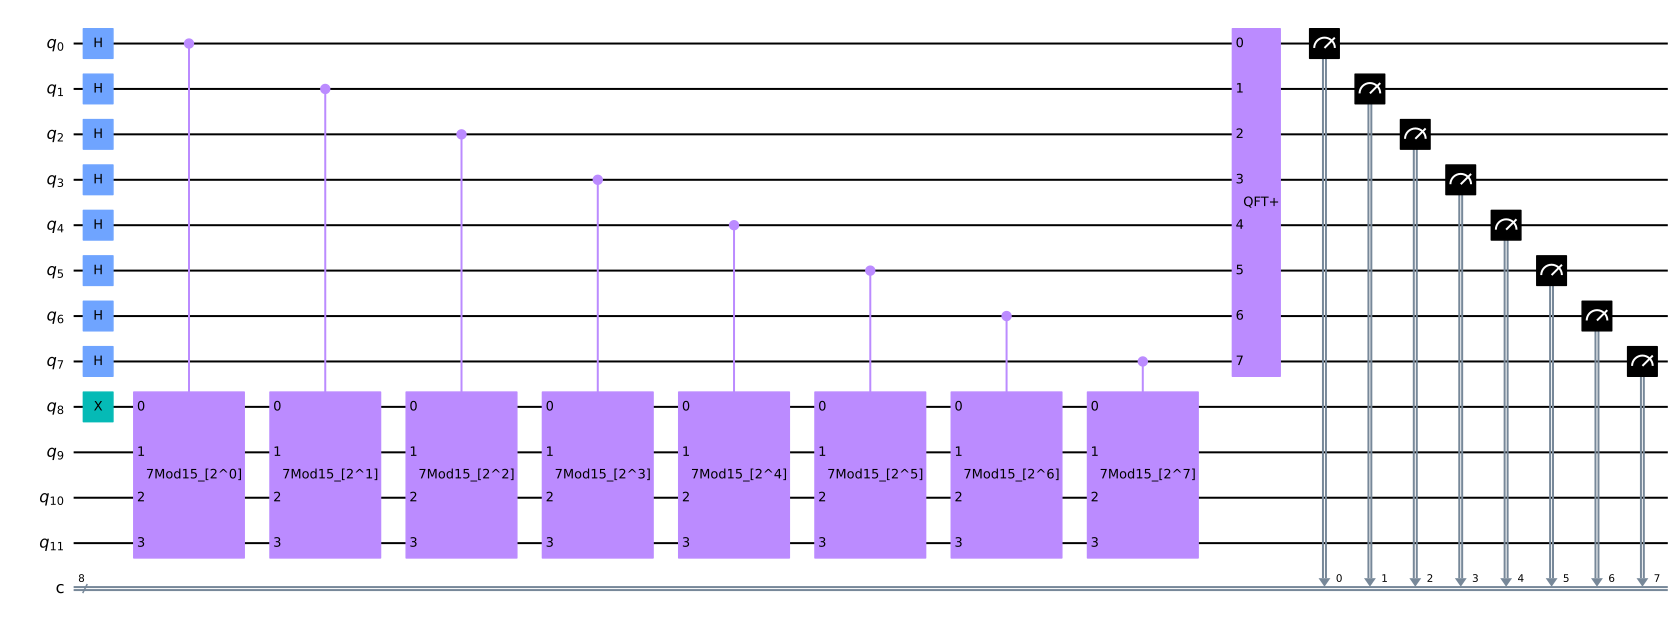

In [8]:
t = 2*m

shor_Orig = QuantumCircuit(t+m, t)
shor_Orig.h(range(t))

shor_Orig.x(t)
for idx in range(t):
    shor_Orig.append(cU_multi(idx), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'

shor_Orig.append(qft_dag, range(t))
shor_Orig.measure(range(t), range(t))
    
shor_Orig.draw()

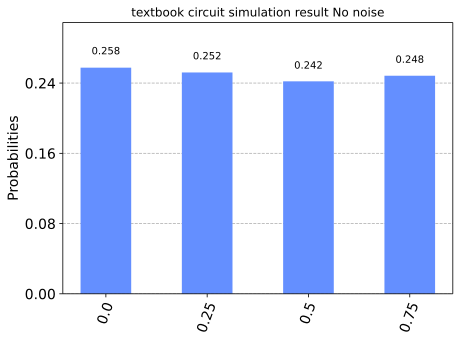

In [9]:
shor_Orig_trans = transpile(shor_Orig, sim)
count_Orig = sim.run(shor_Orig_trans, shots=shots).result().get_counts()
key_new = [str(int(key,2)/2**t) for key in count_Orig.keys()]
count_new_Orig = dict(zip(key_new, count_Orig.values()))
plot_histogram(count_new_Orig, title='textbook circuit simulation result No noise')

#### Perform the noise simulations of two circuits, `shor_Orig`, `shor_QPE`, on the backend `FakeMelbourne` and plot their noise simulation results together with ones without noise for comparison.

Run the following cell. 

In [1]:
from qiskit.test.mock import FakeMelbourne
from qiskit.providers.aer import AerSimulator

backend = FakeMelbourne()
sim_Melborne = AerSimulator.from_backend(backend)

shots=8192

The comparison plot of the simulation results with/without noise for the textbook circuit `shor_Orig` is given below. The code is there to show how the result is generated but not recommended to run as it takes for long time.

In [125]:
# shorOrig_trans = transpile(shor_Orig, backend, optimization_level=3)
# count_shorOrig_noise = sim_Melborne.run(shor_Orig_trans, shots=shots).result().get_counts()

In [172]:
# key_new = [str(np.round(int(key,2)/2**t,3)) for key in count_shorOrig_noise.keys()]
# count_new_Orig_noise = dict(zip(key_new, count_shorOrig_noise.values()))

In [3]:
# fig, ax = plt.subplots(2,1, figsize=(30,13))
# fig.suptitle('Simulation results for the order finding circuit of $7^{r} mod 15 = 1$', fontsize=23)
# plot_histogram(count_new_Orig, ax=ax[0])
# plot_histogram(count_new_Orig_noise, ax=ax[1])
# ax[0].set_title('sim No noise', fontsize=16)
# ax[1].set_title('sim on Melbourne', fontsize=16)
# plt.show()

![](image/L5_textbook_result.png)

&#128211; Carry out the same task for the circuits, `shor_QPE`.

In [ ]:
### your code goes here
















